In [114]:
import numpy as np
import torch
from torch import optim
import os
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from utils.dataloader import train_val_loader, test_loader
from networks.cnn import CNN, CNN_pool, CNN_var
from networks.tests import VisionTransformer
import matplotlib.pyplot as plt
import pyreadr
from scipy.integrate import quad

In [68]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    #result[:, 0] = -(1/0.25)*np.log(params[:,0])
    result[:,0] = np.exp(params[:,0])
    result[:,1] = params[:,1]*2
    return result  

In [107]:
def corr_func(h, method, r, s):
    if method=="powexp":
        res = np.exp(-np.power((h/r),s))
    elif method=="brown":
        res = np.power((h/r),s)
    return res    

In [108]:
def error_function(h, method, true, est):
    r_true, s_true = true
    r_est, s_est = est
    error = np.power(corr_func(h, method, r_true, s_true)- corr_func(h, method, r_est, s_est),2)
    return error

In [147]:
def get_imse(data, method):
    pred = data[0:2]
    params = data[2:4]
    error, _ = quad(error_function, 0, 40, args = (method, pred, params))
    return error

In [181]:
def get_metrics(pred, param, method):
    rmse = np.sqrt(np.mean((np.power(pred-param,2)), axis = 0))
    mae = np.mean(np.abs(pred-param), axis = 0)
    bias = np.mean(pred-param, axis = 0)
    imse = np.mean(np.array([get_imse(x, method) for x in np.append(pred, param, axis = 1)]))
    
    
    print(f"RMSE: {np.round(rmse,2)}")
    print(f"IMSE: {np.round(imse,2)}")
    #print(f"MAE: {np.round(mae,2)}")
    #print(f"Bias: {np.round(bias,2)}")

# Results for Brown-Resnick with new parameter range

## PL

In [70]:
exp = "exp_4"
path = f'../data/{exp}/data/'
brown_params = pyreadr.read_r(path+"brown_test_params.RData")["test_params"].to_numpy()
schlather_params = pyreadr.read_r(path+"powexp_test_params.RData")["test_params"].to_numpy()
path = f'../data/{exp}/results/'
brown_res = pyreadr.read_r(path+"brown_single_image_fit_opt.RData")["results"].to_numpy()
schlather_res = pyreadr.read_r(path+"powexp_single_image_fit_opt.RData")["results"].to_numpy()[:,1:]

In [71]:
get_metrics(brown_res, brown_params)

RMSE: [0.89 0.37]
MAE: [0.53 0.3 ]
Bias: [0.04 0.02]


In [72]:
get_metrics(schlather_res, schlather_params)

RMSE: [1.44 0.69]
MAE: [1.18 0.57]
Bias: [-1.14  0.04]


In [73]:
# Dataloader
exp = "exp_4"
path = f"../data/{exp}/data/"
model = "brown"
dataloader, _ = test_loader(data_path = path, model = model, batch_size = 750)

In [74]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/{model}_cnn_pool.pt"))

<All keys matched successfully>

In [75]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [76]:
pred_tf= retransform(pred)
param_tf= retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [77]:
# Brown metrics
get_metrics(pred_tf,param_tf)

RMSE: [0.46 0.2 ]
MAE: [0.38 0.16]
Bias: [ 0.12 -0.06]


In [78]:
# Plot results
n_comb = 25
n_each = 30

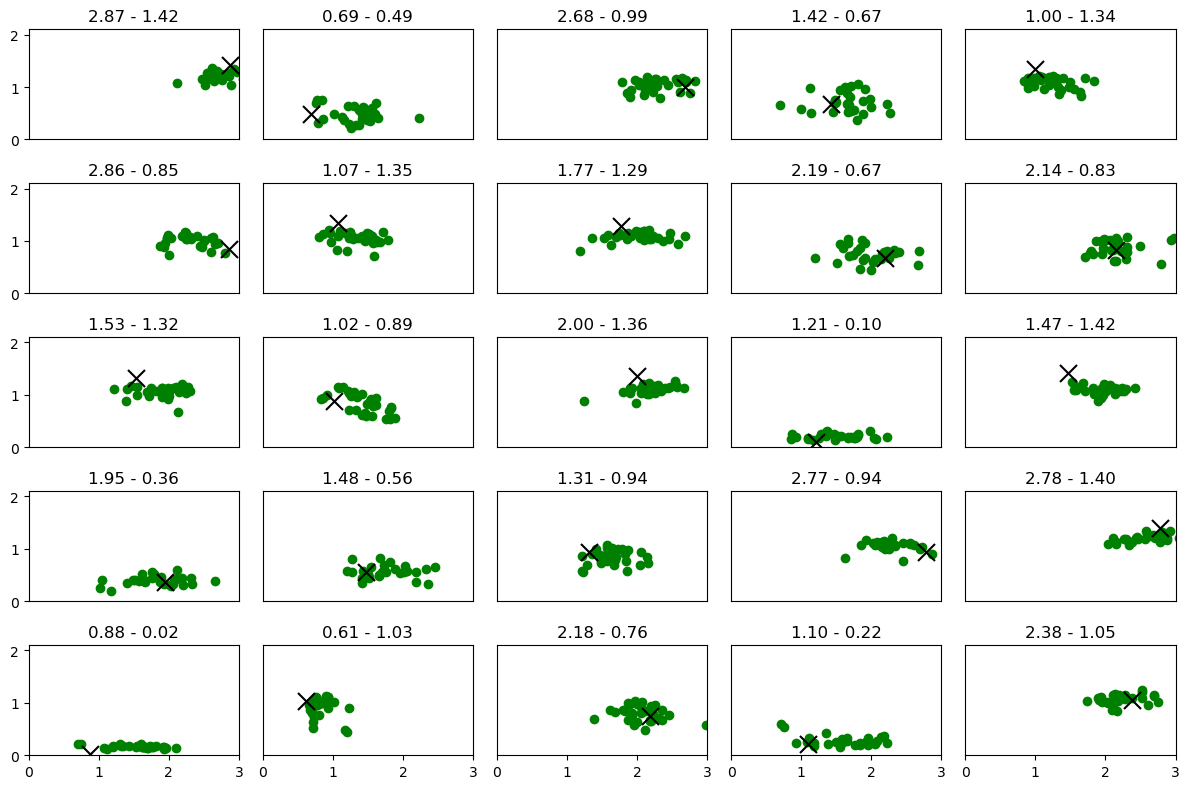

In [79]:
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    axs[i].set_ylim([0,2.1])
    axs[i].set_xlim([0,3])
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

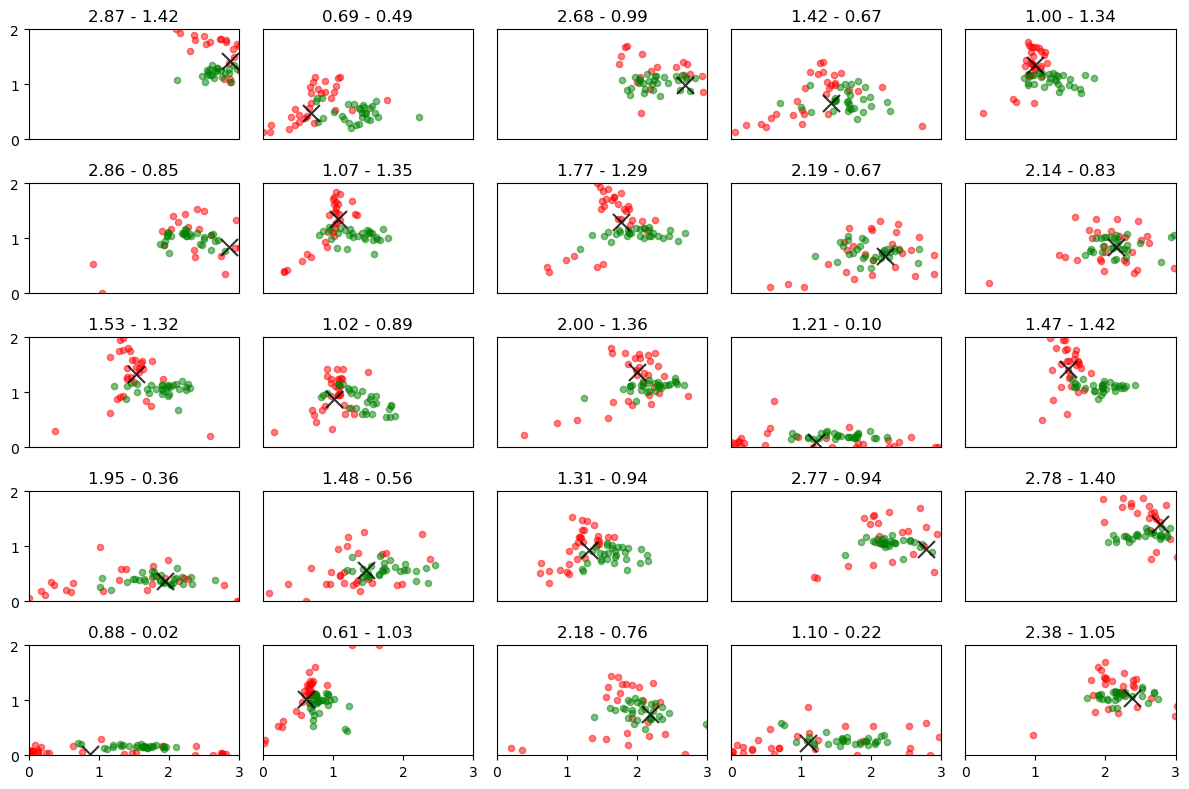

In [80]:
# With Likelihood fixed range

range_1 = 3
range_2 = 2
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = brown_res[(i*n_each):((i+1)*n_each),0], y = brown_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)    
    axs[i].set_xlim([0,range_1])
    axs[i].set_ylim([0,range_2])
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

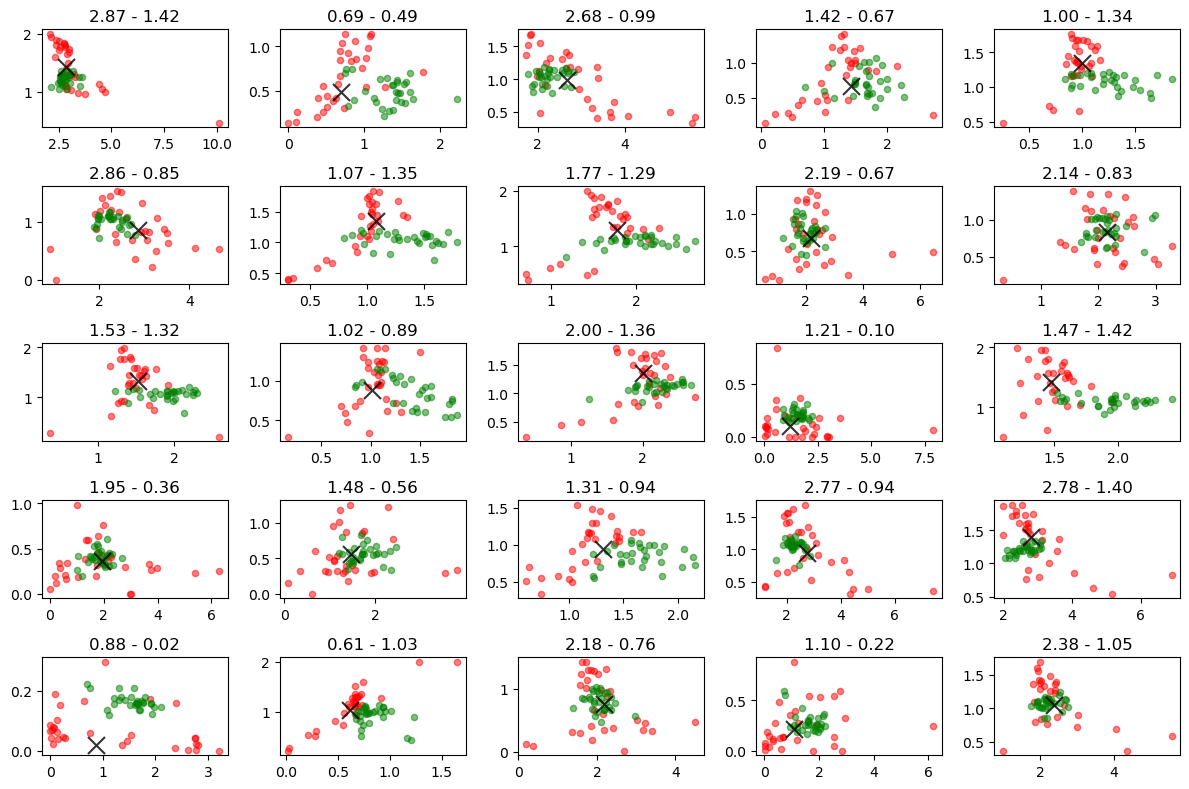

In [81]:
# With Likelihood flexible range
n_comb = 25
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = brown_res[(i*n_each):((i+1)*n_each),0], y = brown_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)    
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

# Results for schlather with new parameter range

In [82]:
# Dataloader
exp = "exp_4"
path = f"../data/{exp}/data/"
model = "powexp"
dataloader, _ = test_loader(data_path = path, model = model, batch_size = 750)

In [83]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/{model}_cnn_pool.pt"))

<All keys matched successfully>

In [84]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [85]:
pred_tf = retransform(pred)
param_tf = retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [86]:
# Schlather metrics
get_metrics(pred_tf,param_tf)

RMSE: [0.44 0.24]
MAE: [0.35 0.19]
Bias: [0.08 0.03]


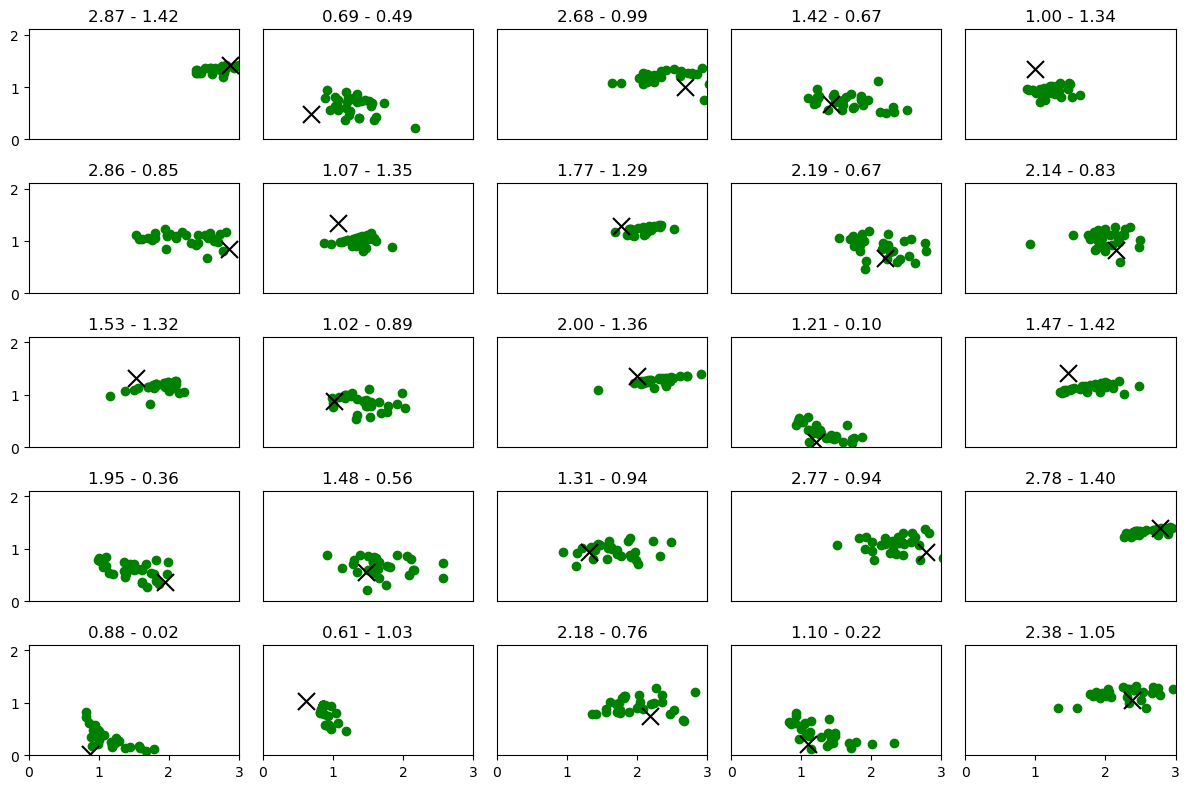

In [87]:
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    axs[i].set_ylim([0,2.1])
    axs[i].set_xlim([0,3])
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

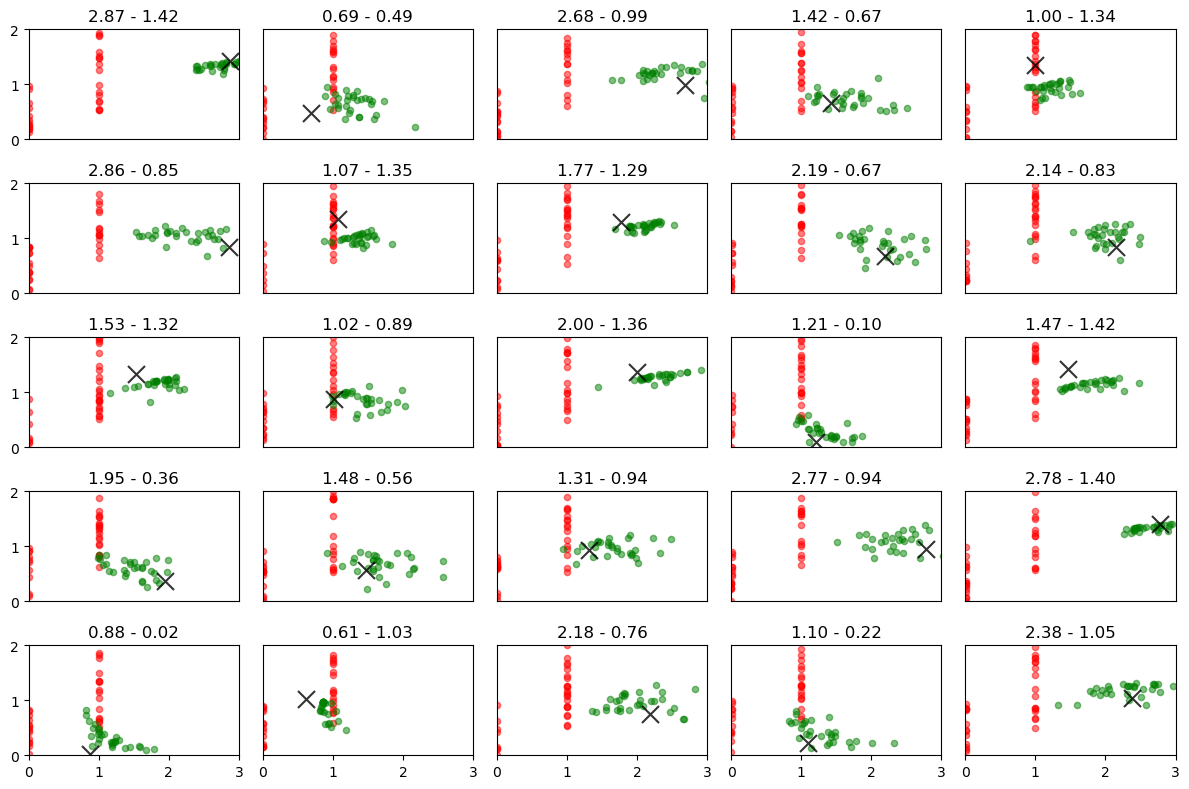

In [88]:
# With Likelihood fixed range

range_1 = 3
range_2 = 2
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = schlather_res[(i*n_each):((i+1)*n_each),0], y = schlather_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)    
    axs[i].set_xlim([0,range_1])
    axs[i].set_ylim([0,range_2])
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

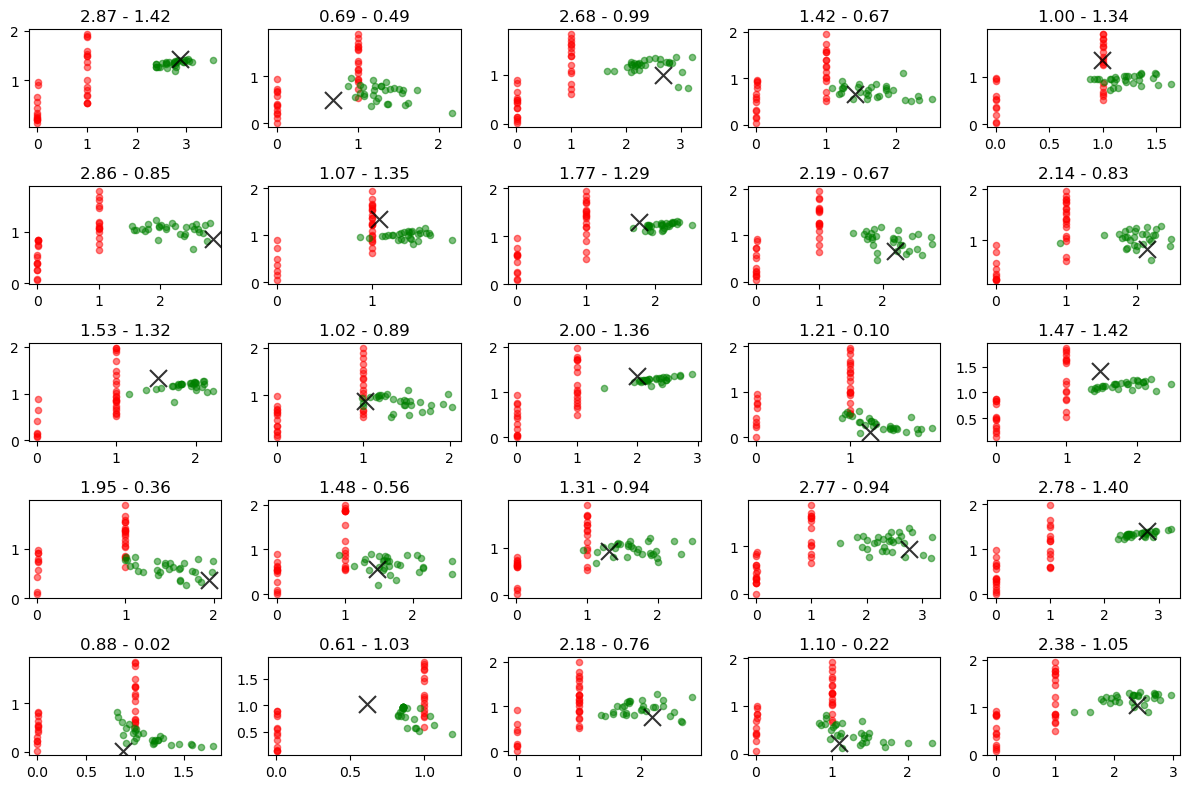

In [89]:
# With Likelihood flexible range
fig, axs = plt.subplots(5,5,figsize = (12,8))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = schlather_res[(i*n_each):((i+1)*n_each),0], y = schlather_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150, alpha = 0.8)   
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

# Results for outside parameters

In [208]:
exp = "exp_4"
path = f'../data/{exp}/data/'
brown_params = pyreadr.read_r(path+"brown_test_params_outside.RData")["test_params"].to_numpy()
schlather_params = pyreadr.read_r(path+"powexp_test_params_outside.RData")["test_params"].to_numpy()
path = f'../data/{exp}/results/'
brown_res = pyreadr.read_r(path+"brown_single_image_fit_opt_outside.RData")["results"].to_numpy()
schlather_res = pyreadr.read_r(path+"powexp_single_image_fit_opt_outside.RData")["results"].to_numpy()[:,1:]

In [209]:
# Dataloader
exp = "exp_4"
path = f"../data/{exp}/data/"
model = "brown"
dataloader, dataset = test_loader(data_path = path, model = model, batch_size = 750)

In [210]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/{model}_cnn_pool.pt"))

<All keys matched successfully>

In [211]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [212]:
pred_tf= retransform(pred)
param_tf= retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [213]:
# Brown metrics CNN
get_metrics(pred_tf,param_tf, "brown")

RMSE: [1.26 0.45]
IMSE: 726165.0


In [183]:
# Brown metrics PL
get_metrics(brown_res, brown_params, "brown")

RMSE: [1.36 0.39]
IMSE: 5847737345.87


In [184]:
# Plot results
n_comb = 8
n_each = 50

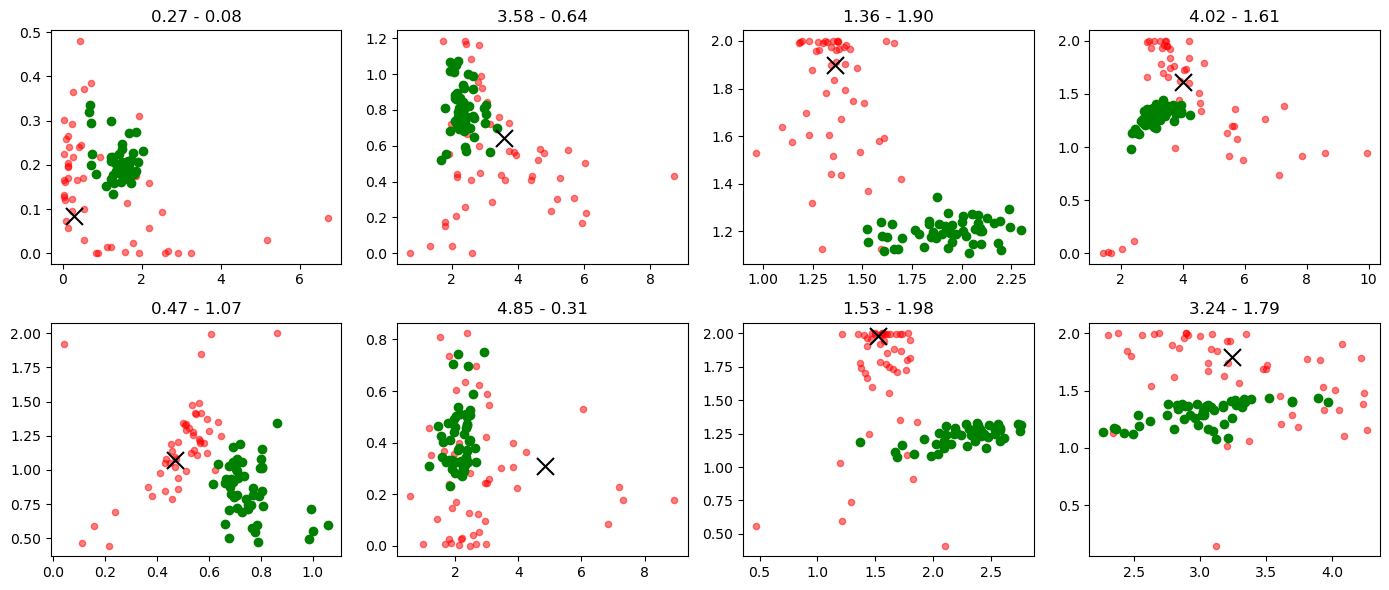

In [185]:
fig, axs = plt.subplots(2,4,figsize = (14,6))
axs = axs.transpose().ravel()
for i in range(n_comb):
    axs[i].scatter(x = brown_res[(i*n_each):((i+1)*n_each),0], y = brown_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

In [186]:
# Dataloader
exp = "exp_4"
path = f"../data/{exp}/data/"
model = "powexp"
dataloader, dataset = test_loader(data_path = path, model = model, batch_size = 750)

In [187]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/{model}_cnn_pool.pt"))

<All keys matched successfully>

In [188]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).detach().numpy()
param = param.detach().numpy()

In [199]:
pred_tf= retransform(pred)
param_tf= retransform(param)
np.save(f"../data/{exp}/results/cnn_{model}.npy", pred_tf)

In [200]:
# Brown metrics
get_metrics(pred_tf,param_tf, "powexp")

RMSE: [1.38 0.46]
IMSE: 0.35


In [191]:
get_metrics(schlather_res, schlather_params, "powexp")

RMSE: [2.49 0.88]
IMSE: 1.18


In [192]:
# Plot results
n_comb = 8
n_each = 50

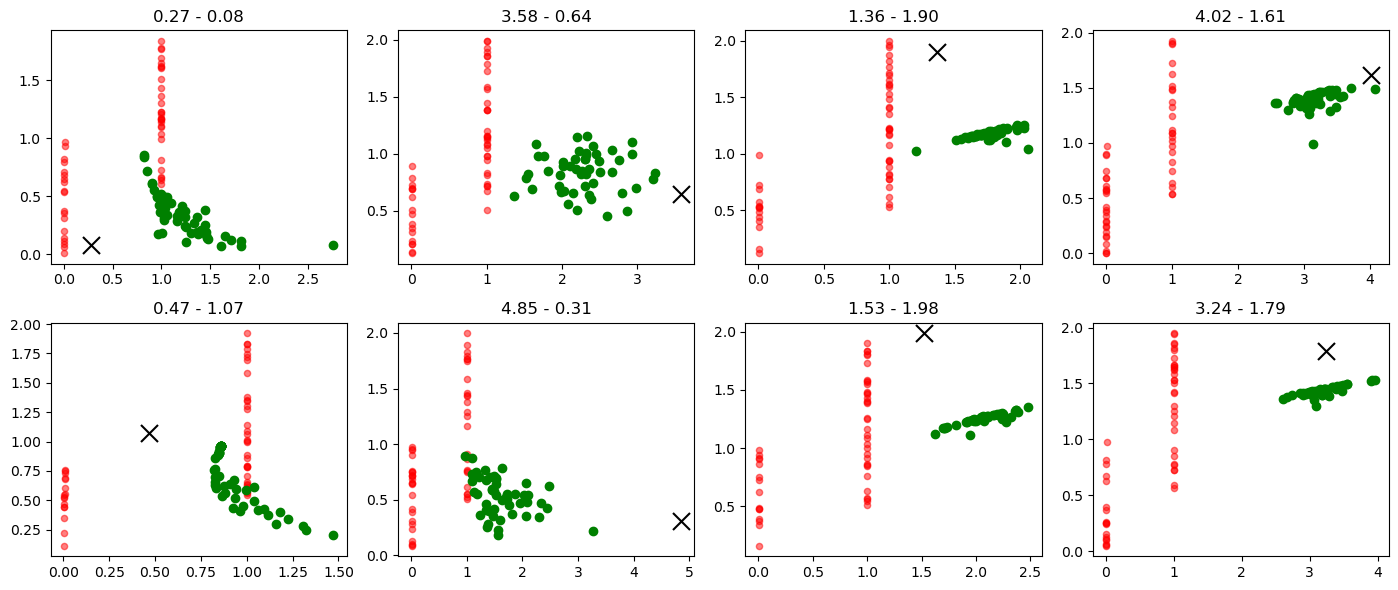

In [193]:
fig, axs = plt.subplots(2,4,figsize = (14,6))
axs = axs.transpose().ravel()
for i in range(n_comb):
    axs[i].scatter(x = schlather_res[(i*n_each):((i+1)*n_each),0], y = schlather_res[(i*n_each):((i+1)*n_each),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
        
fig.tight_layout()

# Results for aggregated model

In [2]:
# Dataloader
exp = "exp_3_1"
path = f"../data/{exp}/data/"
model = "brown"
dataloader, _ = test_loader(data_path = path, model = "brown", batch_size = 2250)

In [3]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/cnn_pool.pt"))
net.eval()

CNN_pool(
  (conv_input): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_64): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=2304, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=2, bias=True)
  (output_1): Linear(in_features=256, out_features=1, bias=True)
  (output_2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

In [4]:
for sample in dataloader:
    img, param, model = sample
    break 
pred = net(img).detach().numpy()
param = param.detach().numpy()
model = model.detach().numpy()

In [5]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    #result[:,0] = params[:,0]*(3-0.1)+0.1
    result[:,0] = np.exp(params[:,0])
    result[:,1] = params[:,1]*2
    return result  

In [6]:
def get_metrics(pred_tf, param_tf):
    rmse = np.sqrt(np.mean((np.power(pred_tf-param_tf,2)), axis = 0))
    mae = np.mean(np.abs(pred_tf-param_tf), axis = 0)
    bias = np.mean(pred_tf-param_tf, axis = 0)
    print(f"RMSE: {np.round(rmse,2)}")
    print(f"MAE: {np.round(mae,2)}")
    print(f"Bias: {np.round(bias,2)}")

In [7]:
pred_tf_full = retransform(pred)
param_tf_full = retransform(param)

In [8]:
# Full metrics
get_metrics(pred_tf_full,param_tf_full)

RMSE: [0.73 0.31]
MAE: [0.56 0.23]
Bias: [-0.03 -0.1 ]


In [9]:
# Brown metrics
get_metrics(pred_tf_full[model==0],param_tf_full[model==0])

RMSE: [0.64 0.19]
MAE: [0.46 0.13]
Bias: [-0.17 -0.05]


In [10]:
#Powexp metrics
get_metrics(pred_tf_full[model==1],param_tf_full[model==1])

RMSE: [0.73 0.36]
MAE: [0.57 0.26]
Bias: [ 0.04 -0.2 ]


In [11]:
#Whitmat metrics
get_metrics(pred_tf_full[model==2],param_tf_full[model==2])

RMSE: [0.82 0.36]
MAE: [0.65 0.3 ]
Bias: [ 0.03 -0.04]


In [12]:
# Plot results
n_comb = 25
n_each = 30

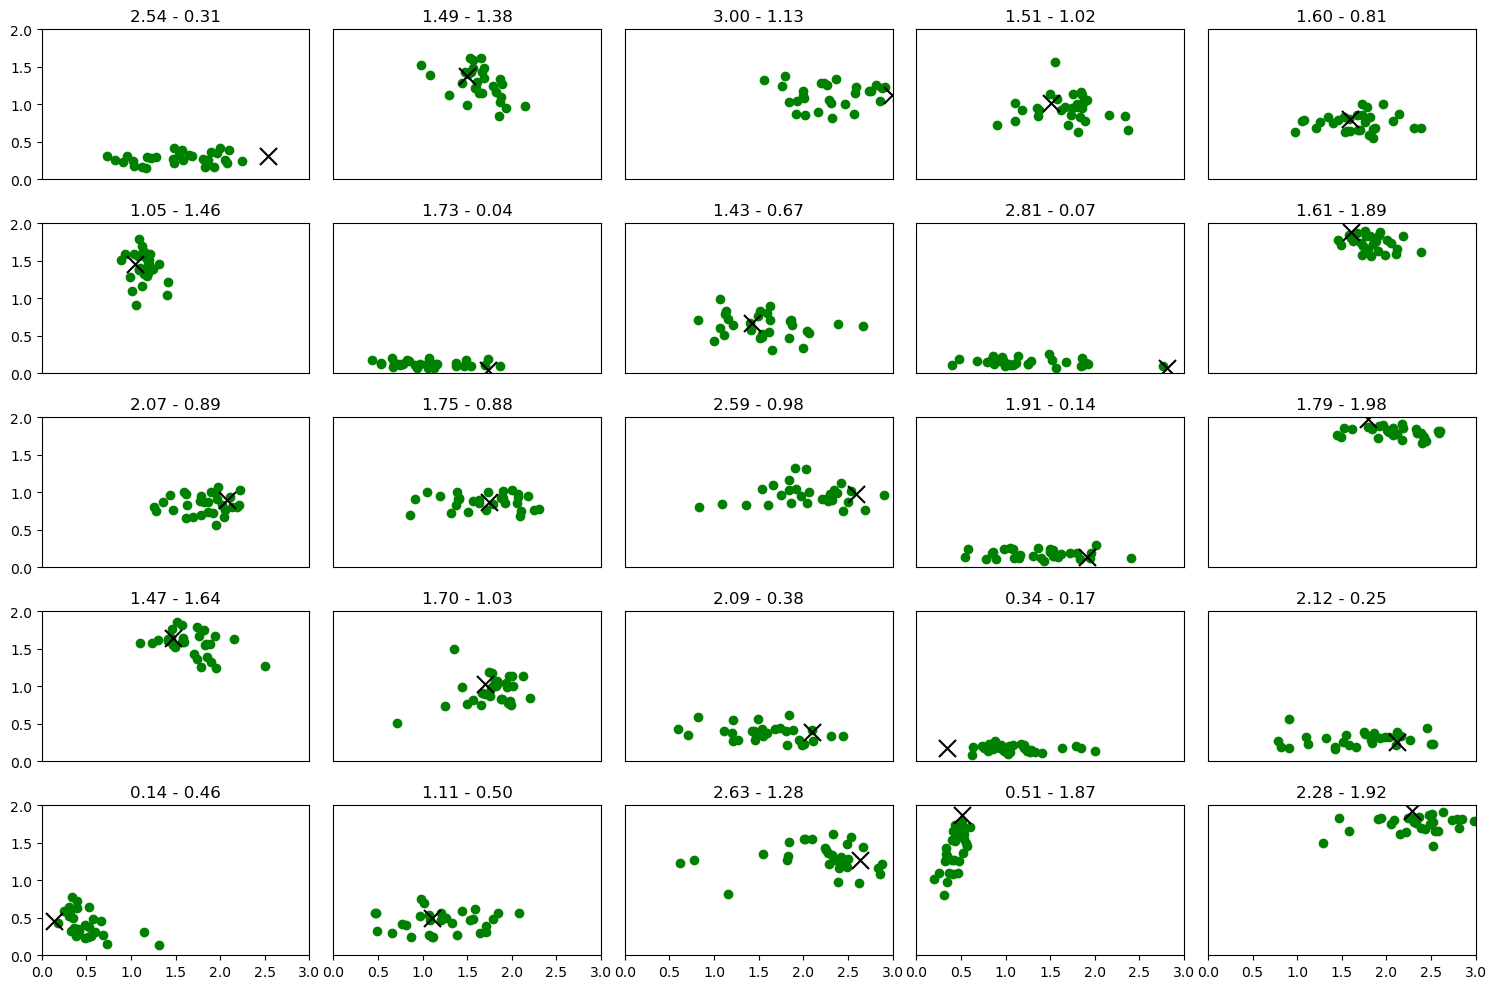

In [16]:
#Brown
pred_tf = pred_tf_full[model==0]
param_tf = param_tf_full[model==0]

fig, axs = plt.subplots(5,5,figsize = (15,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    axs[i].set_ylim([0,2])
    axs[i].set_xlim([0,3])
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

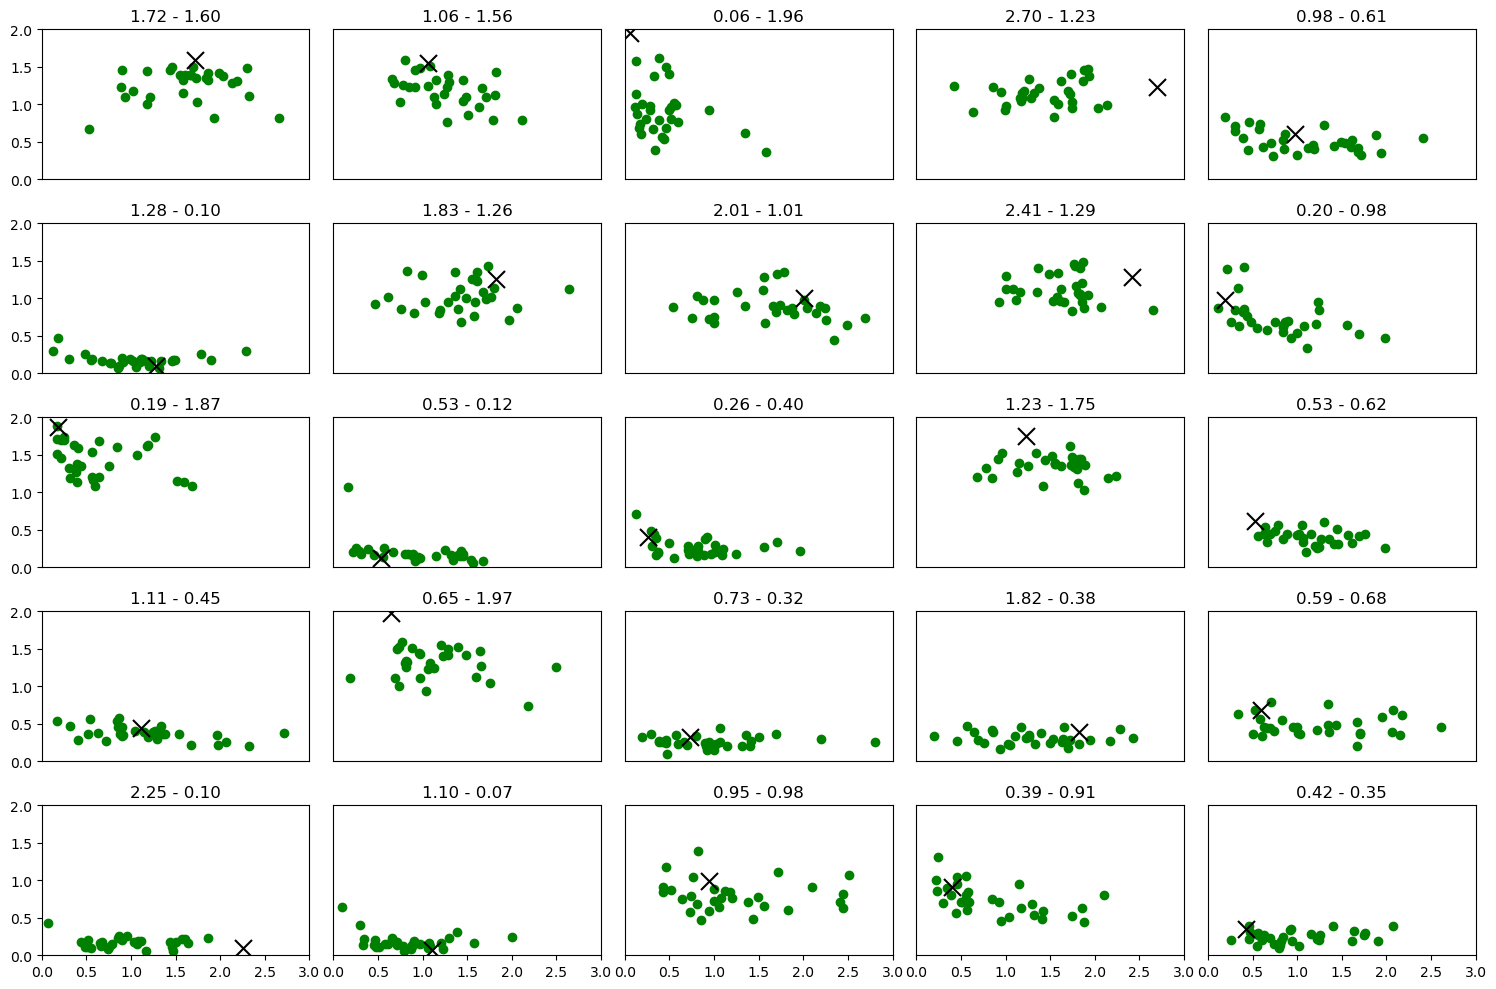

In [14]:
#Powexp
pred_tf = pred_tf_full[model==1]
param_tf = param_tf_full[model==1]

fig, axs = plt.subplots(5,5,figsize = (15,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    axs[i].set_ylim([0,2])
    axs[i].set_xlim([0,3])
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

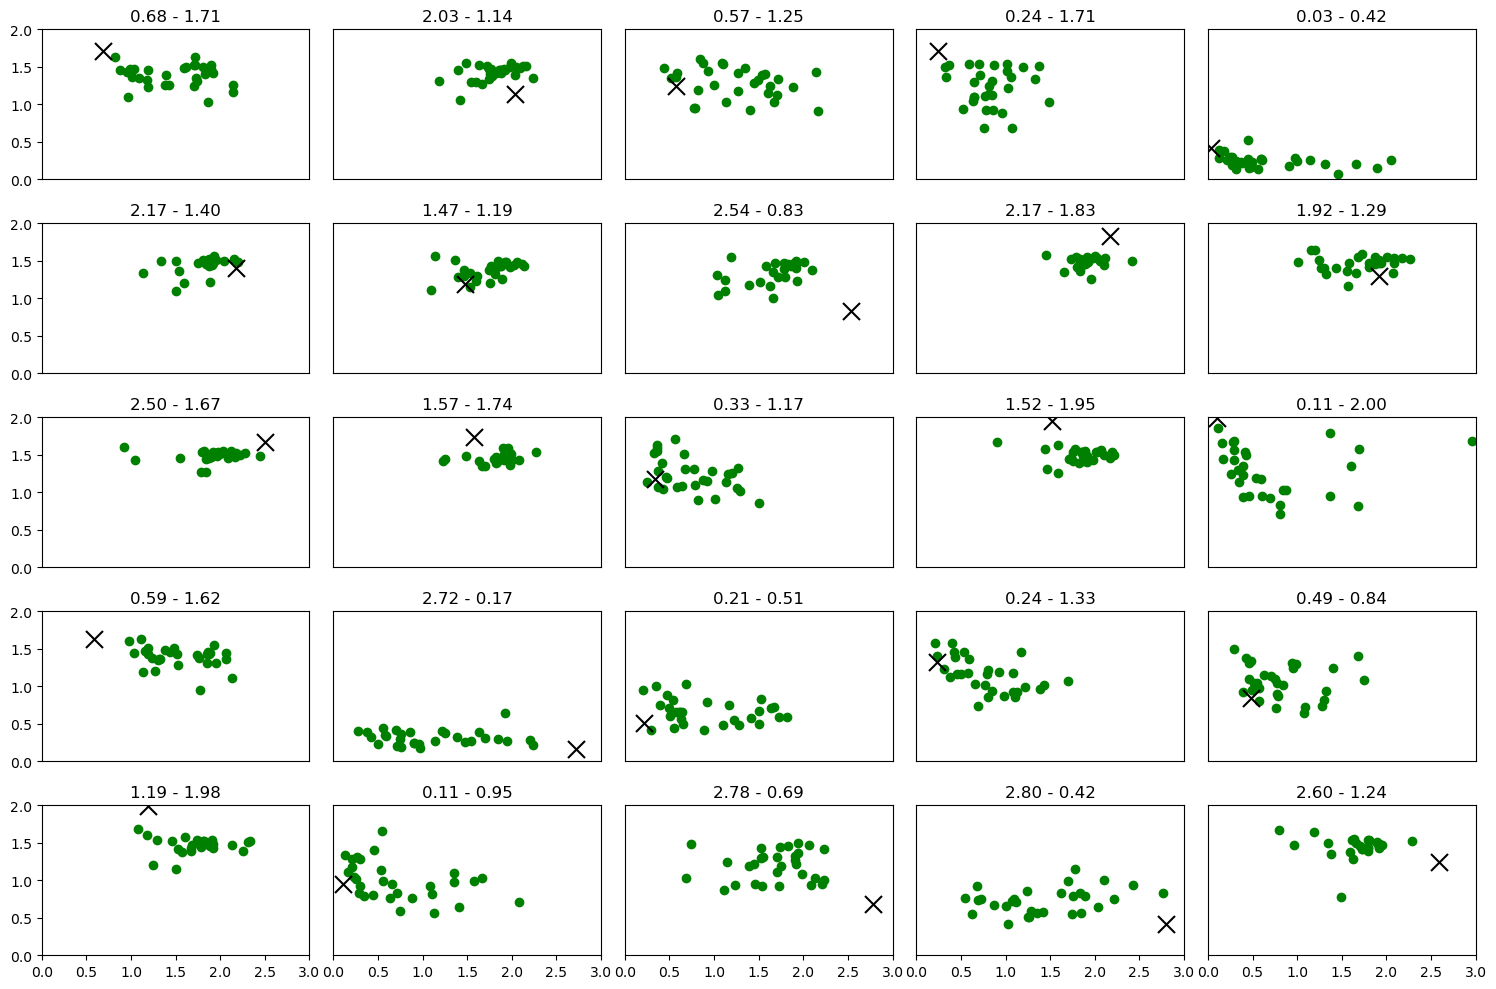

In [15]:
#Whitmat
pred_tf = pred_tf_full[model==2]
param_tf = param_tf_full[model==2]

fig, axs = plt.subplots(5,5,figsize = (15,10))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*n_each):((i+1)*n_each),0], y = pred_tf[(i*n_each):((i+1)*n_each),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*n_each),0], y = param_tf[5+(i*n_each),1], color = "black", marker = "x", s = 150)
    axs[i].set_title(f"{param_tf[5+(i*n_each),0]:.2f} - {param_tf[5+(i*n_each),1]:.2f}")   
    axs[i].set_ylim([0,2])
    axs[i].set_xlim([0,3])
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()